# Compare observer runaways to theory runaways

In [244]:
import cogsworth
import astropy.units as u
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import gala.dynamics as gd

In [245]:
%config InlineBackend.figure_format = 'retina'
plt.style.use("default")


pd.options.display.max_columns = 999

plt.rc('font', family='serif')
plt.rcParams['text.usetex'] = False
fs = 24

# update various fontsizes to match
params = {'figure.figsize': (12, 8),
          'legend.fontsize': fs,
          'axes.labelsize': fs,
          'xtick.labelsize': 0.9 * fs,
          'ytick.labelsize': 0.9 * fs,
          'axes.linewidth': 1.1,
          'xtick.major.size': 7,
          'xtick.minor.size': 4,
          'ytick.major.size': 7,
          'ytick.minor.size': 4}
plt.rcParams.update(params)

# Test updated diagram function

In [256]:
fs = 24

kstar_translator = [
    {'long': 'Main Sequence (Low mass)', 'short': 'MS < 0.7', 'colour': (0.996078, 0.843476, 0.469158, 1.0)},
    {'long': 'Main Sequence', 'short': 'MS', 'colour': (0.996078, 0.843476, 0.469158, 1.0)},
    {'long': 'Hertzsprung Gap', 'short': 'HG', 'colour': (0.939608, 0.471373, 0.094902, 1.0)},
    {'long': 'First Giant Branch', 'short': 'FGB', 'colour': (0.716186, 0.833203, 0.916155, 1.0)},
    {'long': 'Core Helium Burning', 'short': 'CHeB', 'colour': (0.29098, 0.59451, 0.78902, 1.0)},
    {'long': 'Early Asymptotic Giant Branch', 'short': 'EAGB', 'colour': (0.294902, 0.690196, 0.384314, 1.0)},
    {'long': 'Thermally Pulsing Asymptotic Giant Branch', 'short': 'TPAGB',
     'colour': (0.723122, 0.889612, 0.697178, 1.0)},
    {'long': 'Helium Main Sequence', 'short': 'HeMS', 'colour': (0.254627, 0.013882, 0.615419, 1.0)},
    {'long': 'Helium Hertsprung Gap', 'short': 'HeHG', 'colour': (0.562738, 0.051545, 0.641509, 1.0)},
    {'long': 'Helium Giant Branch', 'short': 'HeGB', 'colour': (0.798216, 0.280197, 0.469538, 1.0)},
    {'long': 'Helium White Dwarf', 'short': 'HeWD', 'colour': (0.368166, 0.232828, 0.148275, 1.0)},
    {'long': 'Carbon/Oxygen White Dwarf', 'short': 'COWD', 'colour': (0.620069, 0.392132, 0.249725, 1.0)},
    {'long': 'Oxygen/Neon White Dwarf', 'short': 'ONeWD', 'colour': (0.867128, 0.548372, 0.349225, 1.0)},
    {'long': 'Neutron Star', 'short': 'NS', 'colour': (0.501961, 0.501961, 0.501961, 1.0)},
    {'long': 'Black Hole', 'short': 'BH', 'colour': (0.0, 0.0, 0.0, 1.0)},
    {'long': 'Massless Remnant', 'short': 'MR', 'colour': (1.0, 1.0, 0.0, 1.0)},
    {'long': 'Chemically Homogeneous', 'short': 'CHE', 'colour': (0.647059, 0.164706, 0.164706, 1.0)}
]

# where the colours come from
# for i in [1, 2]:
#     kstar_translator[i]["colour"] = plt.get_cmap("YlOrBr")(0.3 * i)

# for i in [3, 4]:
#     kstar_translator[i]["colour"] = plt.get_cmap("Blues")(0.3 * (i - 2))

# for i in [5, 6]:
#     kstar_translator[i]["colour"] = plt.get_cmap("Greens")(0.3 * (3 - (i - 4)))

# for i in [7, 8, 9]:
#     kstar_translator[i]["colour"] = plt.get_cmap("plasma")(0.1 + 0.2 * (i - 7))

# for i in [10, 11, 12]:
#     kstar_translator[i]["colour"] = plt.get_cmap("copper")(0.1 + 0.2 * (i - 9))

evol_type_translator = [
    None,
    {"sentence": "Initial state", "short": "Init", "long": "Initial state"},
    {"sentence": "a star changed stellar type", "short": "Kstar change", "long": "Stellar type changed"},
    {"sentence": "Roche lobe overflow started", "short": "RLOF start", "long": "Roche lobe overflow started"},
    {"sentence": "Roche lobe overflow ended", "short": "RLOF end", "long": "Roche lobe overflow ended"},
    {"sentence": "the binary entered a contact phase", "short": "Contact", "long": "Binary entered contact phase"},
    {"sentence": "the binary coalesced", "short": "Coalescence", "long": "Binary coalesced"},
    {"sentence": "a common envelope phase started", "short": "CE start", "long": "Common-envelope started"},
    {"sentence": "the common envelope phase ended", "short": "CE end", "long": "Common-envelope ended"},
    {"sentence": "no remnant leftover", "short": "No remnant", "long": "No remnant"},
    {"sentence": "the maximum evolution time was reached", "short": "Max evol time", "long": "Maximum evolution time reached"},
    {"sentence": "the binary was disrupted", "short": "Disruption", "long": "Binary disrupted"},
    {"sentence": "a symbiotic phase started", "short": "Begin symbiotic phase", "long": "Begin symbiotic phase"},
    {"sentence": "a symbiotic phase ended", "short": "End symbiotic phase", "long": "End symbiotic phase"},
    {"sentence": "Blue straggler", "short": "Blue straggler", "long": "Blue straggler"},
    {"sentence": "the primary went supernova", "short": "SN1", "long": "Supernova of primary"},
    {"sentence": "the secondary went supernova", "short": "SN2", "long": "Supernova of secondary"},
]


def _use_white_text(rgba):
    """Determines whether to use white text on a given background color based on the RGBA value.

    Parameters
    ----------
    rgba : `tuple`
        RGBA value

    Returns
    -------
    flag : `bool`
        True if white text should be used
    """
    r, g, b, _ = rgba
    return (r * 0.299 + g * 0.587 + b * 0.114) < 186 / 255


def _supernova_marker(ax, x, y, s):
    """Add a supernova marker to an ax

    Parameters
    ----------
    ax : :class:`~matplotlib.pyplot.axis`
        Axis on which to add marker
    x : `float`
        x coordinate
    y : `float`
        y coordinate
    s : `float`
        Size scale
    """
    ax.scatter(x, y, marker=(15, 1, 0), s=s * 6, zorder=-1,
               facecolor="#ebd510", edgecolor="#ebb810", linewidth=2)
    ax.scatter(x, y, marker=(10, 1, 0), s=s * 4, zorder=-1,
               facecolor="orange", edgecolor="#eb7e10", linewidth=2)


def _rlof_path(centre, width, height, m=1.5, flip=False):
    """Draw a path in the shape of RLOF (teardrop)

    Parameters
    ----------
    centre : `tuple`
        Centre of the teardrop (x, y)
    width : `float`
        How wide to make
    height : `float`
        How tall to make it
    m : `float`, optional
        The 'pointy-ness' of the teardrop, by default 1.5
    flip : `bool`, optional
        Whether to flip the direction, by default False

    Returns
    -------
    x, y : :class:`~numpy.ndarray`
        Path of the teardrop
    """
    t = np.linspace(0, 2 * np.pi, 1000)
    x = 0.5 * width * np.cos(t) * (-1 if flip else 1) + centre[0]
    y = height * np.sin(t) * np.sin(0.5 * t)**(m) + centre[1]

    return x, y


def translate_COSMIC_tables(tab, kstars=True, evol_type=True, label_type="short", replace_columns=True):
    """Translate COSMIC BSE tables to human-readable labels

    Parameters
    ----------
    tab : :class:`~pandas.DataFrame`
        Evolution table from COSMIC
    kstars : `bool`, optional
        Whether to translate kstar_1 and kstar_2, by default True
    evol_type : `bool`, optional
        Whether to translate evol_type, by default True
    label_type : `str`, optional
        Type of label (either "short" or "long"), by default "short"
    replace_columns : `bool`, optional
        Whether to replace original columns (if not new ones are appended), by default True

    Returns
    -------
    translated_tab : :class:`~pandas.DataFrame`
        The translated table
    """
    if kstars:
        unique_kstars = np.unique(tab[["kstar_1", "kstar_2"]].values).astype(int)
        kstar_1_str = np.array([None for _ in range(len(tab))])
        kstar_2_str = np.array([None for _ in range(len(tab))])
        for kstar in unique_kstars:
            kstar_1_str[tab["kstar_1"] == kstar] = kstar_translator[kstar][label_type]
            kstar_2_str[tab["kstar_2"] == kstar] = kstar_translator[kstar][label_type]

        if replace_columns:
            tab.loc[:, "kstar_1"] = kstar_1_str
            tab.loc[:, "kstar_2"] = kstar_2_str
        else:
            tab.loc[:, "kstar_1_str"] = kstar_1_str
            tab.loc[:, "kstar_2_str"] = kstar_2_str

    if evol_type:
        unique_evol_types = np.unique(tab["evol_type"].values).astype(int)
        evol_type_str = np.array([None for _ in range(len(tab))])
        for evol_type in unique_evol_types:
            evol_type_str[tab["evol_type"] == evol_type] = evol_type_translator[evol_type][label_type]

        if replace_columns:
            tab.loc[:, "evol_type"] = evol_type_str
        else:
            tab.loc[:, "evol_type_str"] = evol_type_str

    return tab


def plot_cartoon_evolution(bpp, bin_num, label_type="long", plot_title="Cartoon Binary Evolution",
                           y_sep_mult=1.5, offset=0.2, s_base=1000, show=True):    # pragma: no cover
    """Plot COSMIC bpp output as a cartoon evolution

    Parameters
    ----------
    bpp : `pandas.DataFrame`
        COSMIC bpp table
    bin_num : `int`
        Binary number of the binary to plot
    label_type : `str`, optional
        What sort of annotated labels to use ["short", "long", "sentence"], by default "long"
    plot_title : `str`, optional
        Title to use for the plot, use "" for no title, by default "Cartoon Binary Evolution"
    y_sep_mult : `float`, optional
        Multiplier to use for the y separation (larger=more spread out steps, longer figure)
    offset : `float`, optional
        Offset from the centre for each of the stars (larger=wider binaries)
    s_base : `float`, optional
        Base scatter point size for the stars

    Returns
    -------
    fig, ax : :class:`~matplotlib.pyplot.figure`, :class:`~matplotlib.pyplot.axis`
        Figure and axis of the plot
    """
    # extract the pertinent information from the bpp table
    df = bpp.loc[bin_num][["tphys", "mass_1", "mass_2", "kstar_1", "kstar_2", "porb", "evol_type", "RRLO_1"]]

    # add some offset kstar columns to tell what type a star *previously* was
    df[["prev_kstar_1", "prev_kstar_2"]] = df.shift(1, fill_value=0)[["kstar_1", "kstar_2"]]

    # count the number of evolution steps and start figure with size based on that
    total = len(df)
    fig, ax = plt.subplots(figsize=(12, total * y_sep_mult))

    # instantiate some flags to track state of binary
    i = 0
    disrupted = False
    common_envelope = False
    rlof = False

    # go through each row of the evolution
    for _, row in df.iterrows():
        # use the translators to convert evol_type and kstars
        et_ind, k1, k2, pk1, pk2 = int(row["evol_type"]), kstar_translator[int(row["kstar_1"])],\
            kstar_translator[int(row["kstar_2"])], kstar_translator[int(row["prev_kstar_1"])],\
            kstar_translator[int(row["prev_kstar_2"])]
        et = evol_type_translator[et_ind]

        # set disrupted, rlof and common-envelope flags are necessary
        if et_ind == 11 or row["porb"] < 0.0:
            disrupted = True
        if et_ind == 3:
            rlof = True
        if et_ind == 4:
            rlof = False
        if et_ind == 7:
            common_envelope = True
        if et_ind == 8:
            common_envelope = False

        # check if either star is now a massless remnant
        mr_1 = k1["short"] == "MR"
        mr_2 = k2["short"] == "MR"
        ks_fontsize = 0.3 * fs

        # start an evolution label variable
        evol_label = et[label_type]

        # if the star just evolved then edit to label to explain what happened
        if et_ind == 2:
            which_star = "Primary" if k1 != pk1 else "Secondary"
            to_type = k1[label_type] if k1 != pk1 else k2[label_type]
            evol_label = f'{which_star} evolved to\n{to_type}'

        # annotate the evolution label and time either side of the binary
        ax.annotate(evol_label, xy=(0.5, total - i), va="center")
        ax.annotate(f'{row["tphys"]:1.2e} Myr' if row["tphys"] > 1e4 else f'{row["tphys"]:1.2f} Myr',
                    xy=(-offset - 0.3, total - i), ha="right", va="center",
                    fontsize=0.4*fs, fontweight="bold")

        # if we've got a common envelope then draw an ellipse behind the binary
        if common_envelope:
            envelope = mpl.patches.Ellipse(xy=(0, total - i), width=4 * offset, height=1.5,
                                           facecolor="orange", edgecolor="none", zorder=-1, alpha=0.5)
            envelope_edge = mpl.patches.Ellipse(xy=(0, total - i), width=4 * offset, height=1.5,
                                           facecolor="none", edgecolor="darkorange", lw=2)
            ax.add_artist(envelope)
            ax.add_artist(envelope_edge)

        # if either star is a massless remnant then we're just dealing with a single star now
        if mr_1 or mr_2:
            # plot the star centrally and a little larger
            ax.scatter(0, total - i, color=k1["colour"] if mr_2 else k2["colour"], s=s_base * 1.5)

            # label its stellar type if (a) it changed or (b) we're at the start/end of evolution
            if (k1 != pk1 and not mr_1) or (k2 != pk2 and not mr_2) or et_ind in [1, 10]:
                ax.annotate(k1["short"] if mr_2 else k2["short"], xy=(0, total - i),
                            ha="center", va="center", zorder=10, fontsize=ks_fontsize, fontweight="bold",
                            color="white" if _use_white_text(k1["colour"]
                                                             if mr_2 else k2["colour"]) else "black")

            # annotate the correct mass
            ax.annotate(f'{row["mass_1"] if mr_2 else row["mass_2"]:1.2f} ' + r'$\rm M_{\odot}$',
                        xy=(0, total - i - 0.45), ha="center", va="top", fontsize=0.3*fs)

            # if a supernova just happened then add an explosion marker behind the star
            if et_ind in [15, 16]:
                _supernova_marker(ax, 0, total - i, s_base)

        # otherwise we've got two stars
        else:
            # plot stars offset from the centre
            ax.scatter(0 - offset, total - i, color=k1["colour"], s=s_base, zorder=10)
            ax.scatter(0 + offset, total - i, color=k2["colour"], s=s_base, zorder=10)

            # annotate the mass (with some extra padding if there's RLOF)
            mass_y_offset = 0.35 if not (rlof and not common_envelope) else 0.5
            ax.annotate(f'{row["mass_1"]:1.2f} ' + r'$\rm M_{\odot}$',
                        xy=(0 - offset, total - i - mass_y_offset), ha="center", va="top", fontsize=0.3*fs)
            ax.annotate(f'{row["mass_2"]:1.2f} ' + r'$\rm M_{\odot}$',
                        xy=(0 + offset, total - i - mass_y_offset), ha="center", va="top", fontsize=0.3*fs)

            # if the primary type changed or we're at the start/end then label it
            if k1 != pk1 or et_ind in [1, 10]:
                ax.annotate(k1["short"], xy=(0 - offset, total - i),
                            ha="center", va="center",
                            color="white" if _use_white_text(k1["colour"]) else "black",
                            zorder=10, fontsize=ks_fontsize, fontweight="bold")

            # if the secondary type changed or we're at the start/end then label it
            if k2 != pk2 or et_ind in [1, 10]:
                ax.annotate(k2["short"], xy=(0 + offset, total - i),
                            ha="center", va="center",
                            color="white" if _use_white_text(k2["colour"]) else "black",
                            zorder=10, fontsize=ks_fontsize, fontweight="bold")

            # for bound binaries plot a line connecting them
            if not disrupted:
                ax.plot([0 - offset, 0 + offset], [total - i, total - i],
                        linestyle="--", zorder=-1, color="black")

                # annotate the line with period, offset to one side if there's RLOF
                x = 0 if not (rlof and not common_envelope) else (-offset / 4 if row["RRLO_1"] >= 1.0 else offset / 4)
                ax.annotate(f'{row["porb"]:1.2e} days' if row["porb"] > 10000 or row["porb"] < 1 else f'{row["porb"]:1.0f} days',
                            xy=(x, total - i + 0.05), ha="center", va="bottom", fontsize=0.2*fs if row["porb"] > 10000 or row["porb"] < 1 else 0.3*fs)

            # for non-common-envelope RLOF, plot a RLOF teardrop in the background
            if rlof and not common_envelope:
                # flip the shape depending on the direction
                if row["RRLO_1"] >= 1.0:
                    x, y = _rlof_path((0 - offset / 2.6, total - i), 2 * offset, 0.6, flip=False)
                else:
                    x, y = _rlof_path((0 + offset / 2.6, total - i), 2 * offset, 0.6, flip=True)
                ax.plot(x, y, color="darkorange", lw=2)
                ax.fill_between(x, y, color="orange", alpha=0.5, edgecolor="none", zorder=-2)

            # add supernova explosion markers as necessary
            if et_ind == 15:
                _supernova_marker(ax, 0 - offset, total - i, s_base / 1.5)
            if et_ind == 16:
                _supernova_marker(ax, 0 + offset, total - i, s_base / 1.5)

        # increment by multiplier
        i += y_sep_mult

    # clear off any x-ticks and axes
    ax.set_xlim(-1.5, 1.5)
    ax.set_xticks([])
    ax.axis("off")

    # annotate a title as the top
    ax.annotate(plot_title, xy=(0, total + 0.75), ha="center", va="center", fontsize=fs * 1.2)

    if show:
        plt.show()

    return fig, ax

In [248]:
bpp = pd.read_hdf("/mnt/home/twagg/ceph/pops/boundedness/alpha_1.0.h5", key="bpp")

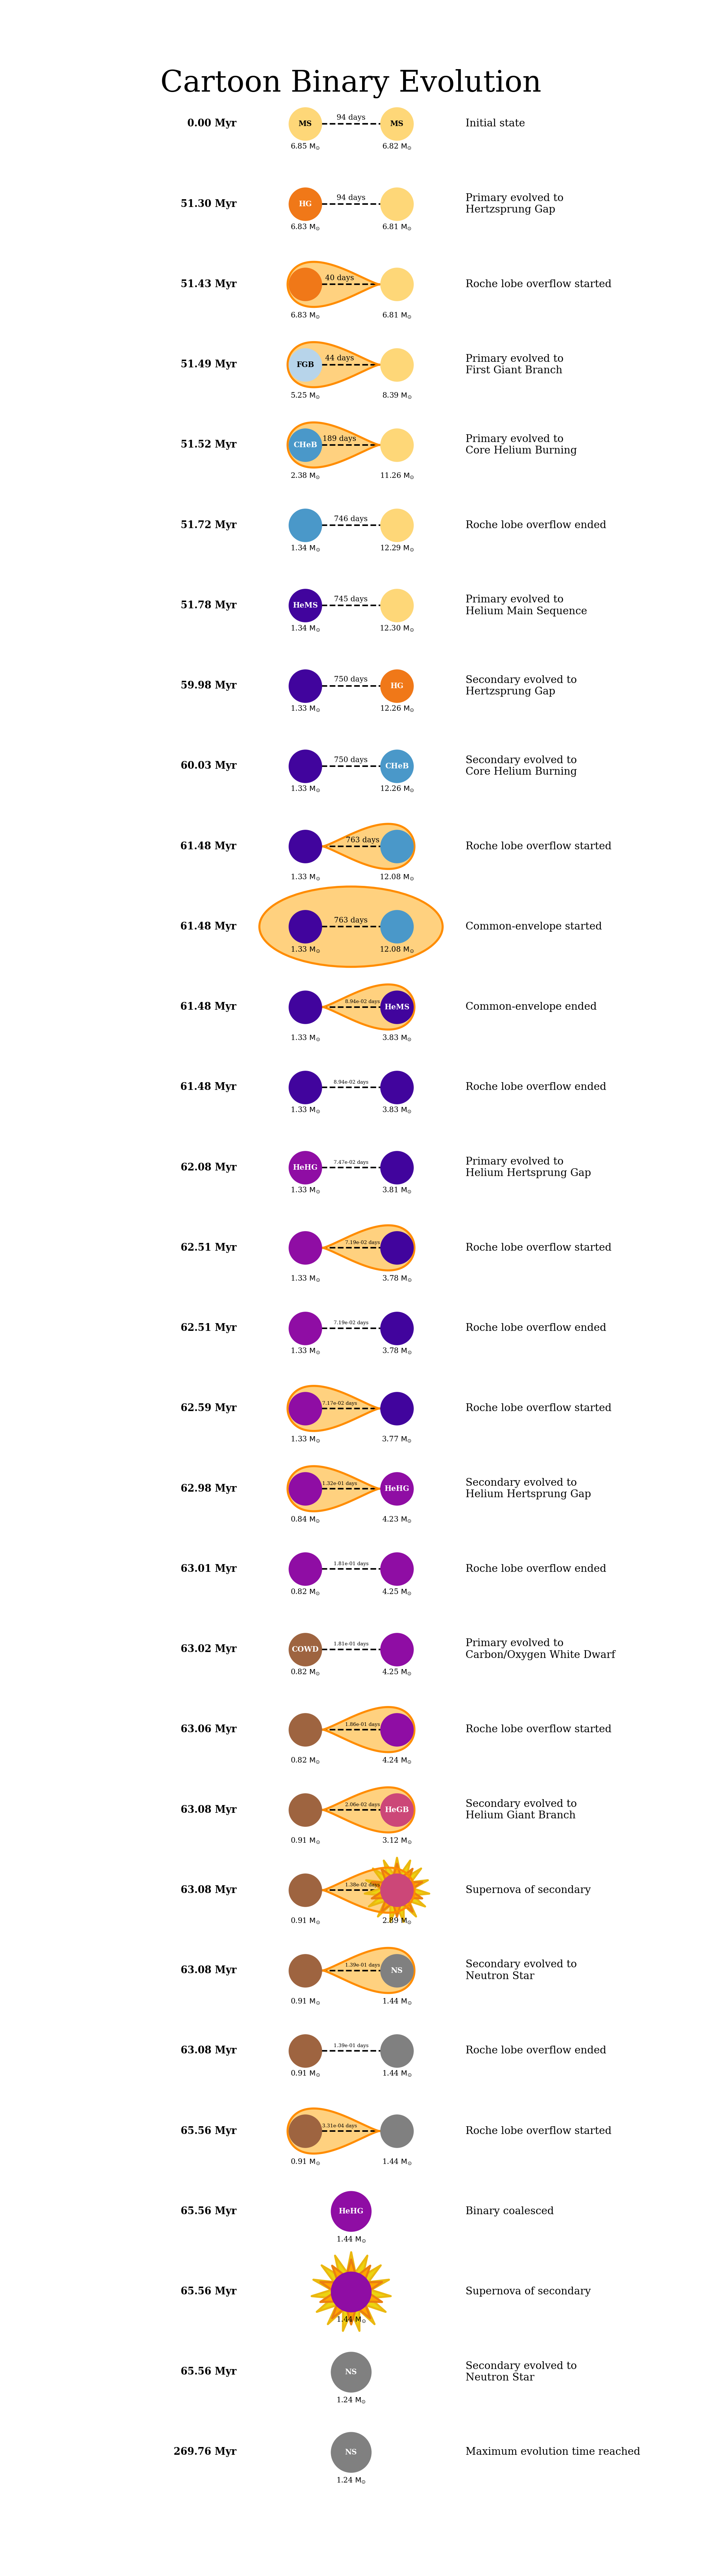

(<Figure size 1200x4500 with 1 Axes>, <Axes: >)

In [257]:
plot_cartoon_evolution(bpp, 2120765)

# The plan

Currently observations of runaways are not measuring quite the same things as theory predicts and this may cause confusion when trying to constrain models making predictions of runaways.

Observations of runaways define them as stars which have a velocity
$$v = || v_{2, \rm today} - v_{\rm Gal}(x_{\rm today}) || > 30 \, {\rm km / s}$$
whereas theoretical predictions instead require
$$v = || v_{2, \rm SN1} - v_{\rm CM, SN1} || > 30 \, {\rm km / s}$$


The key difference here being that the star will have moved far from the original supernova location and so you could be comparing two very different populations. We're going to check how different these values actually are on a population level and so the two things we want to answer are:

1. How much does the velocity change (i.e. $v_{\rm 2, TAMS}$ vs. $v_{\rm 2, SN1}$) for runaway stars
2. How different are the observational and theory velocities

# Prep data

## First the simulation

In [44]:
p = cogsworth.pop.load("/mnt/home/twagg/ceph/pops/boundedness/alpha_0.1")

In [68]:
p.final_coords

(<SkyCoord (Galactocentric: galcen_coord=<ICRS Coordinate: (ra, dec) in deg
     (266.4051, -28.936175)>, galcen_distance=8.122 kpc, galcen_v_sun=(12.9, 245.6, 7.78) km / s, z_sun=20.8 pc, roll=0.0 deg): (x, y, z) in kpc
     [(10.86870093, -1.9235262 , 0.81180817),
      (10.8681567 , -1.92229814, 0.81076418),
      (10.86737168, -1.92328562, 0.81120879), ...,
      (-6.39081533, -4.83787241, 0.3539488 ),
      (-6.44431078, -4.87352409, 0.36405695),
      (-6.43566976, -4.81337901, 0.36462372)]
  (v_x, v_y, v_z) in km / s
     [(18.97544321,  83.27577421, 52.34715485),
      (17.97128548,  84.30149331, 51.14185901),
      (18.31677838,  84.46923881, 50.49614229), ...,
      (41.81110386, -95.61262848, 15.17133523),
      (40.9054988 , -96.18648819, 15.28521452),
      (41.12315008, -95.38222017, 15.27458642)]>,
 <SkyCoord (Galactocentric: galcen_coord=<ICRS Coordinate: (ra, dec) in deg
     (266.4051, -28.936175)>, galcen_distance=8.122 kpc, galcen_v_sun=(12.9, 245.6, 7.78) km / s, z

## Then the star particles

In [46]:
star_particles = pd.read_hdf("FIRE_star_particles.h5")
try:
    particle_orbits = np.load("particle_orbits.npy", allow_pickle=True)
except:
    particle_orbits = [None for _ in range(len(star_particles))]
    for i in range(len(star_particles)):
        if i % 1000 == 0:
            print(i)
        w0 = gd.PhaseSpacePosition(pos=star_particles.iloc[i][["x", "y", "z"]].values * u.kpc,
                                vel=star_particles.iloc[i][["v_x", "v_y", "v_z"]].values * u.km / u.s)
        min_dt = (p.max_ev_time - star_particles.iloc[i]["t_form"] * u.Gyr).to(u.Myr).value
        if min_dt <= 0.01:
            continue
        particle_orbits[i] = p.galactic_potential.integrate_orbit(w0,
                                                                  t1=star_particles.iloc[i]["t_form"] * u.Gyr,
                                                                  t2=p.max_ev_time,
                                                                  dt=min(min_dt - 0.01, 1) * u.Myr)
    np.save("particle_orbits.npy", particle_orbits)

# Select out the right binaries

We only want things that:
1. Received a supernova kick at some point
2. After that time, had a secondary on the main sequence with Teff > 30,000 K

In [75]:
was_kicked = (p.bpp["evol_type"] == 15) | (p.bpp["evol_type"] == 16)
kicked_bin_nums = p.bpp["bin_num"][was_kicked].values
kicked_mask = np.isin(p.bin_nums, kicked_bin_nums)

In [76]:
p_kick = p[kicked_bin_nums]

In [204]:
p_runaways = p_kick[p_kick.bpp[(p_kick.bpp["kstar_2"] <= 1) & (p_kick.bpp["teff_2"] >= 30000)]["bin_num"].unique()]

# Velocity changes

In [212]:
p

<Population - 1135079 evolved systems - galactic_potential=CompositePotential, galaxy_model=Galaxy>

In [225]:
from matplotlib.colors import LogNorm

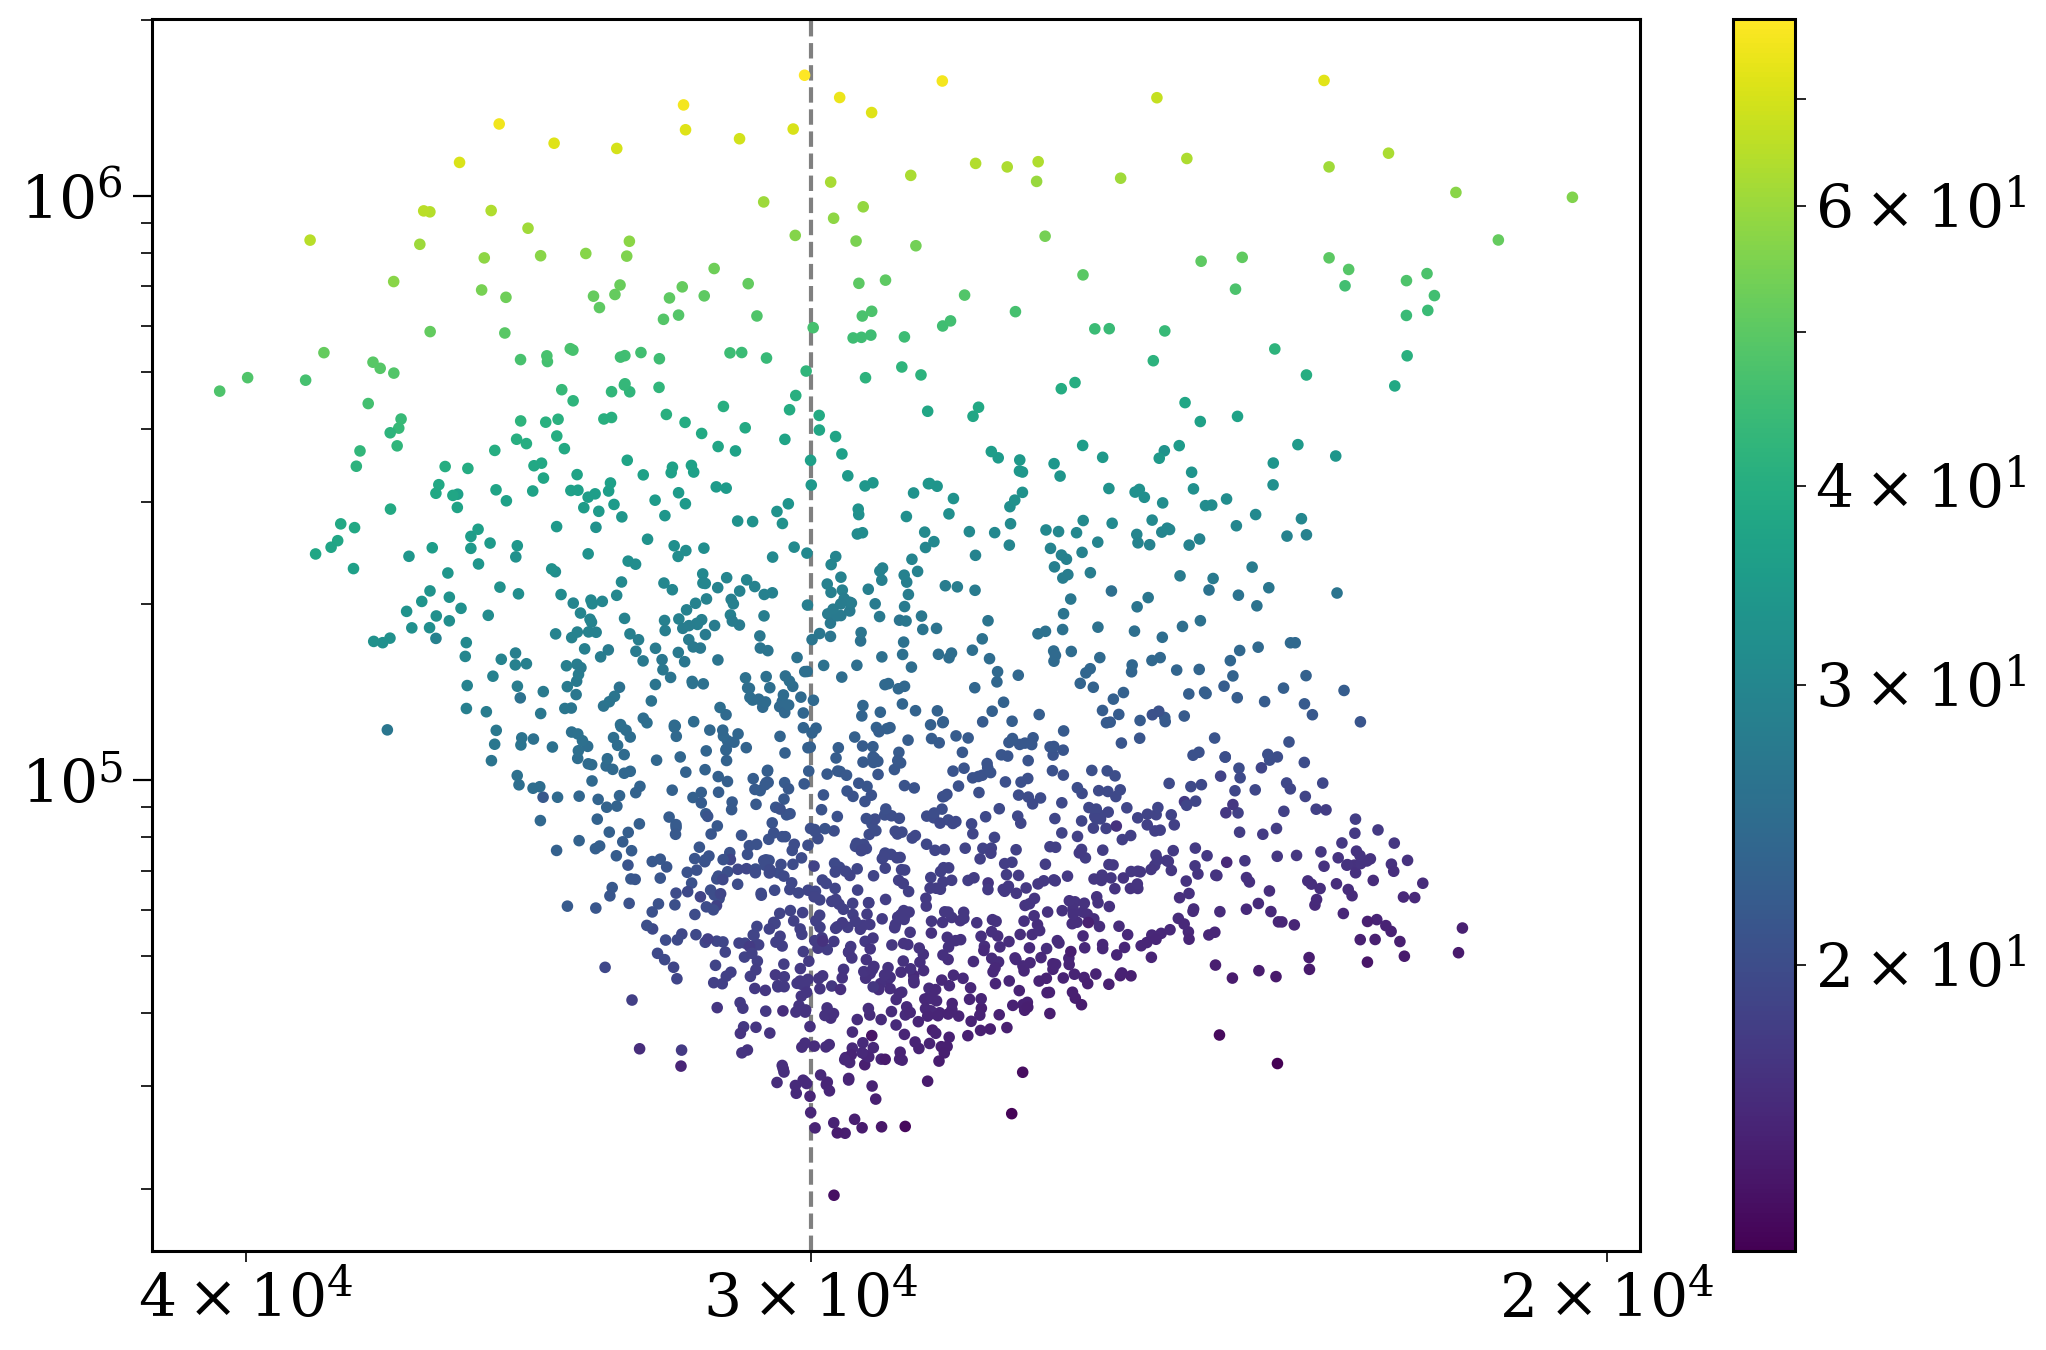

In [230]:
scatter = plt.scatter(*p_runaways.final_bpp[["teff_2", "lum_2"]].values.T, s=10, c=p_runaways.final_bpp["mass_2"], norm=LogNorm())
plt.colorbar(scatter)
plt.xscale("log")
plt.yscale("log")
plt.gca().invert_xaxis()
plt.axvline(30000, color="grey", zorder=-1, linestyle="--")

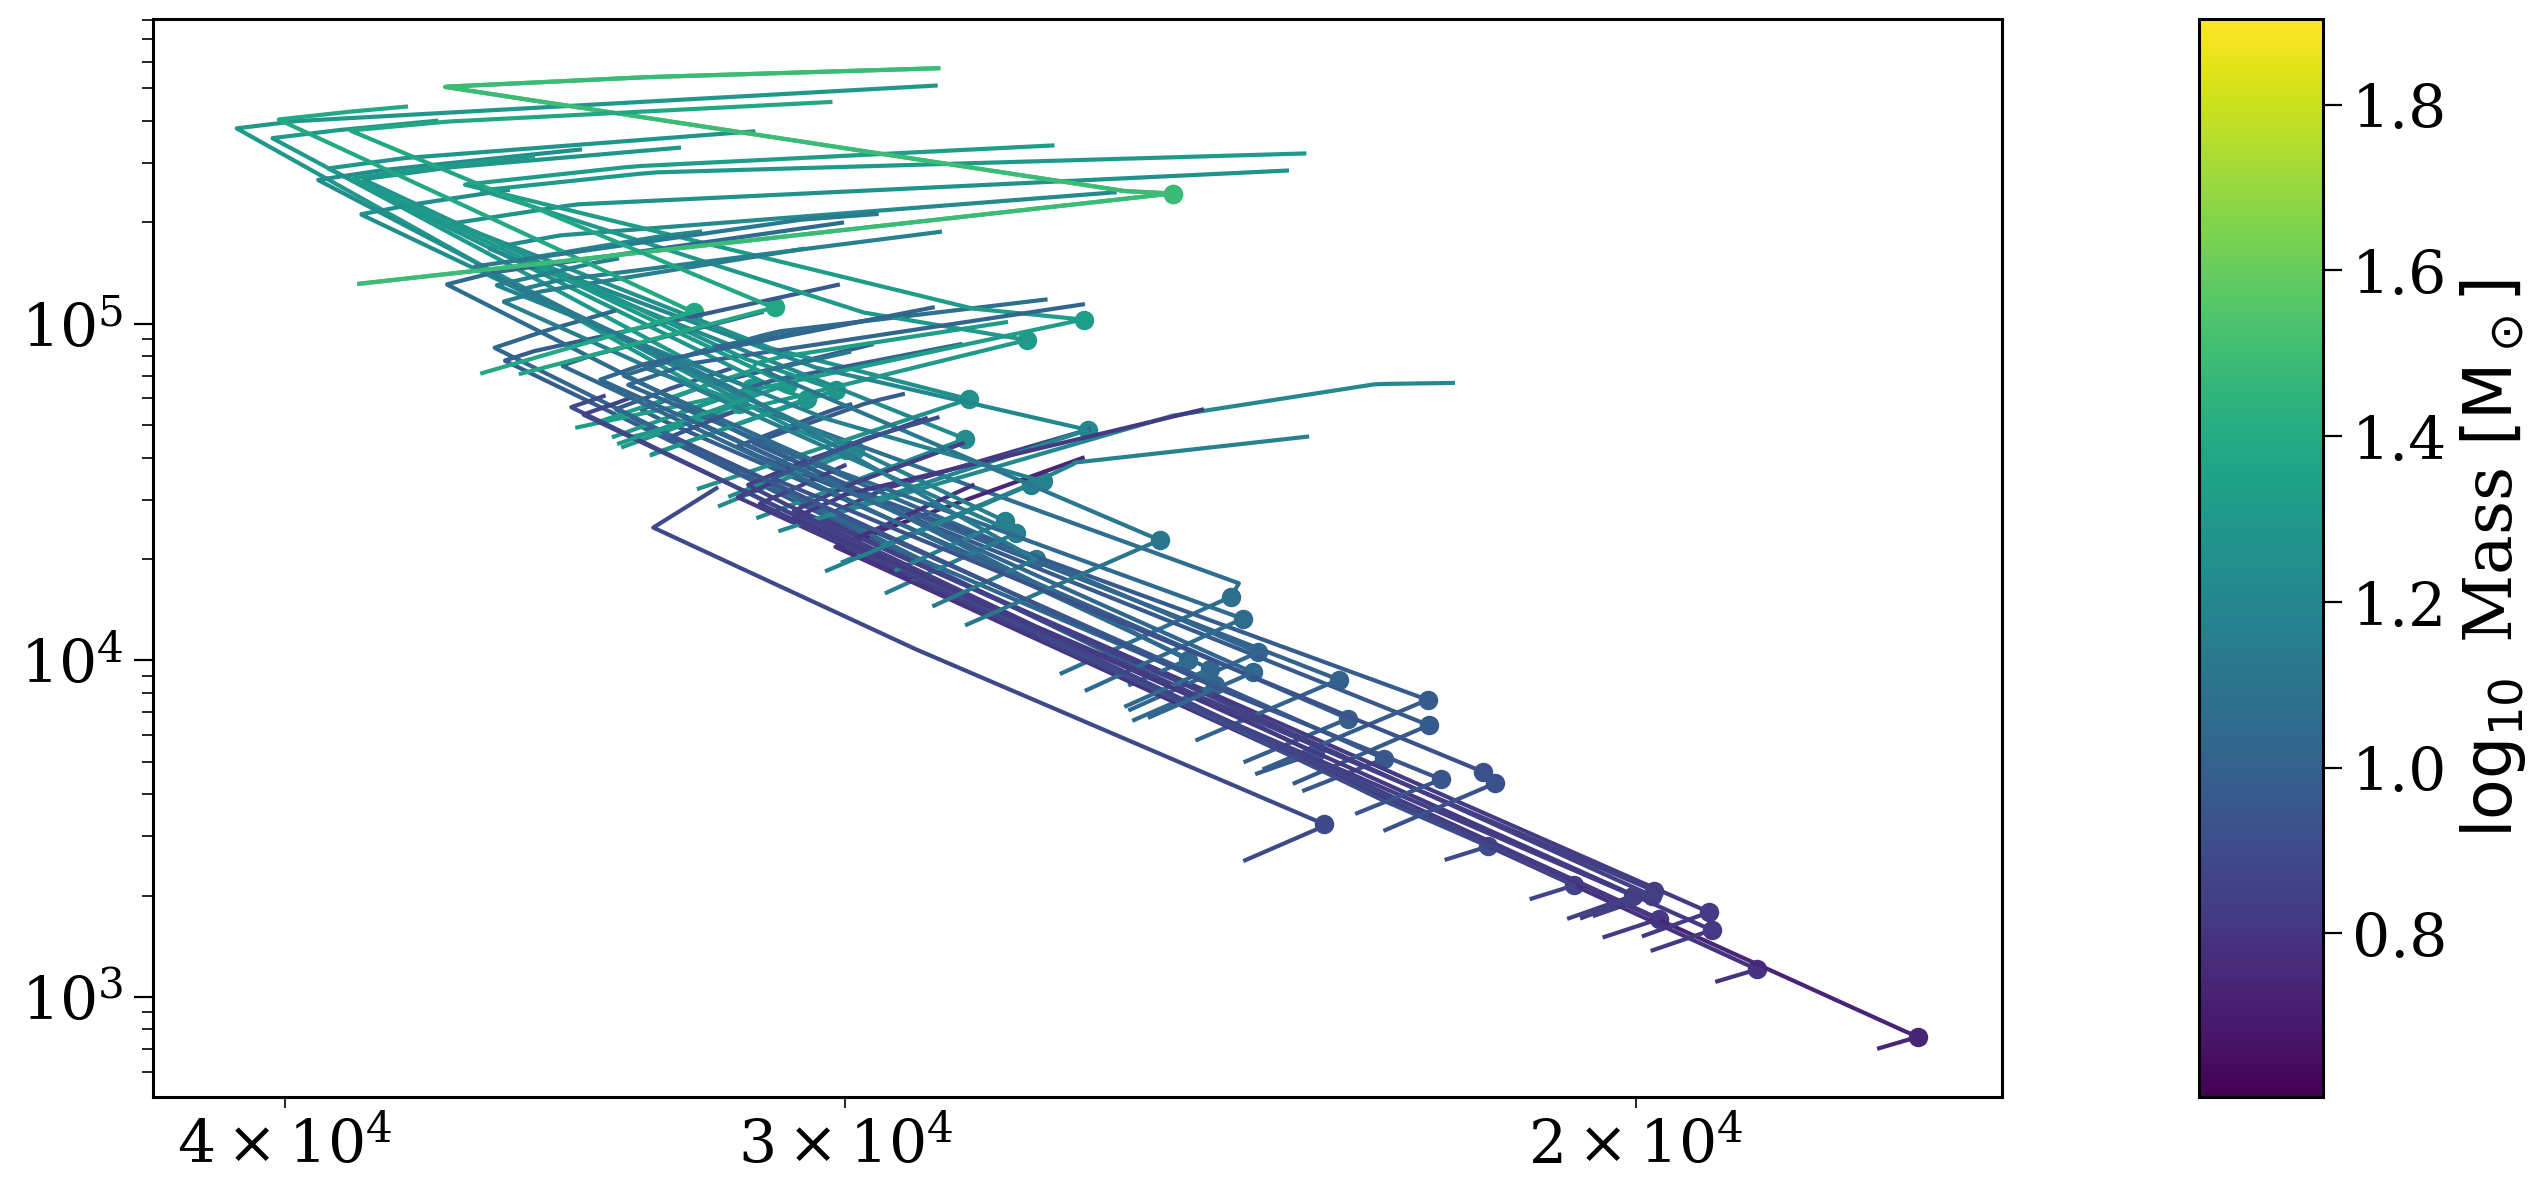

In [205]:
fig, axes = plt.subplots(1, 2, figsize=(14, 7), gridspec_kw={"width_ratios": [15, 1]})
ax, cbar_ax = axes

cmap = plt.cm.viridis

for bin_num in p_runaways.bin_nums[np.random.randint(len(p_runaways), size=50)]:
    # print(p_runaways.bpp.loc[bin_num][["teff_2", "lum_2"]])
    m = np.log10(p_runaways.initC.loc[bin_num]["mass_2"])
    m = (m - np.log10(4)) / (np.log10(80) - np.log10(4))
    ax.plot(*p_runaways.bpp.loc[bin_num][["teff_2", "lum_2"]].values.T, c=cmap(m))
    ax.scatter(*p_runaways.bpp.loc[bin_num][p_runaways.bpp.loc[bin_num]["evol_type"] == 3][["teff_2", "lum_2"]].values.T, color=cmap(m))
    
ax.set(xscale="log", yscale="log")
ax.invert_xaxis()

norm = mpl.colors.Normalize(vmin=np.log10(4), vmax=np.log10(80))
cbar = mpl.colorbar.ColorbarBase(cbar_ax, cmap=cmap, norm=norm, label=r"$\log_{10}$ Mass $[\rm M_\odot]$")
                                   
plt.show()

(array([ 38., 329., 436., 282., 231., 111.,  66.,  32.,  19.,  10.]),
 array([0.65487494, 0.78148219, 0.90808943, 1.03469668, 1.16130392,
        1.28791116, 1.41451841, 1.54112565, 1.6677329 , 1.79434014,
        1.92094738]),
 <BarContainer object of 10 artists>)

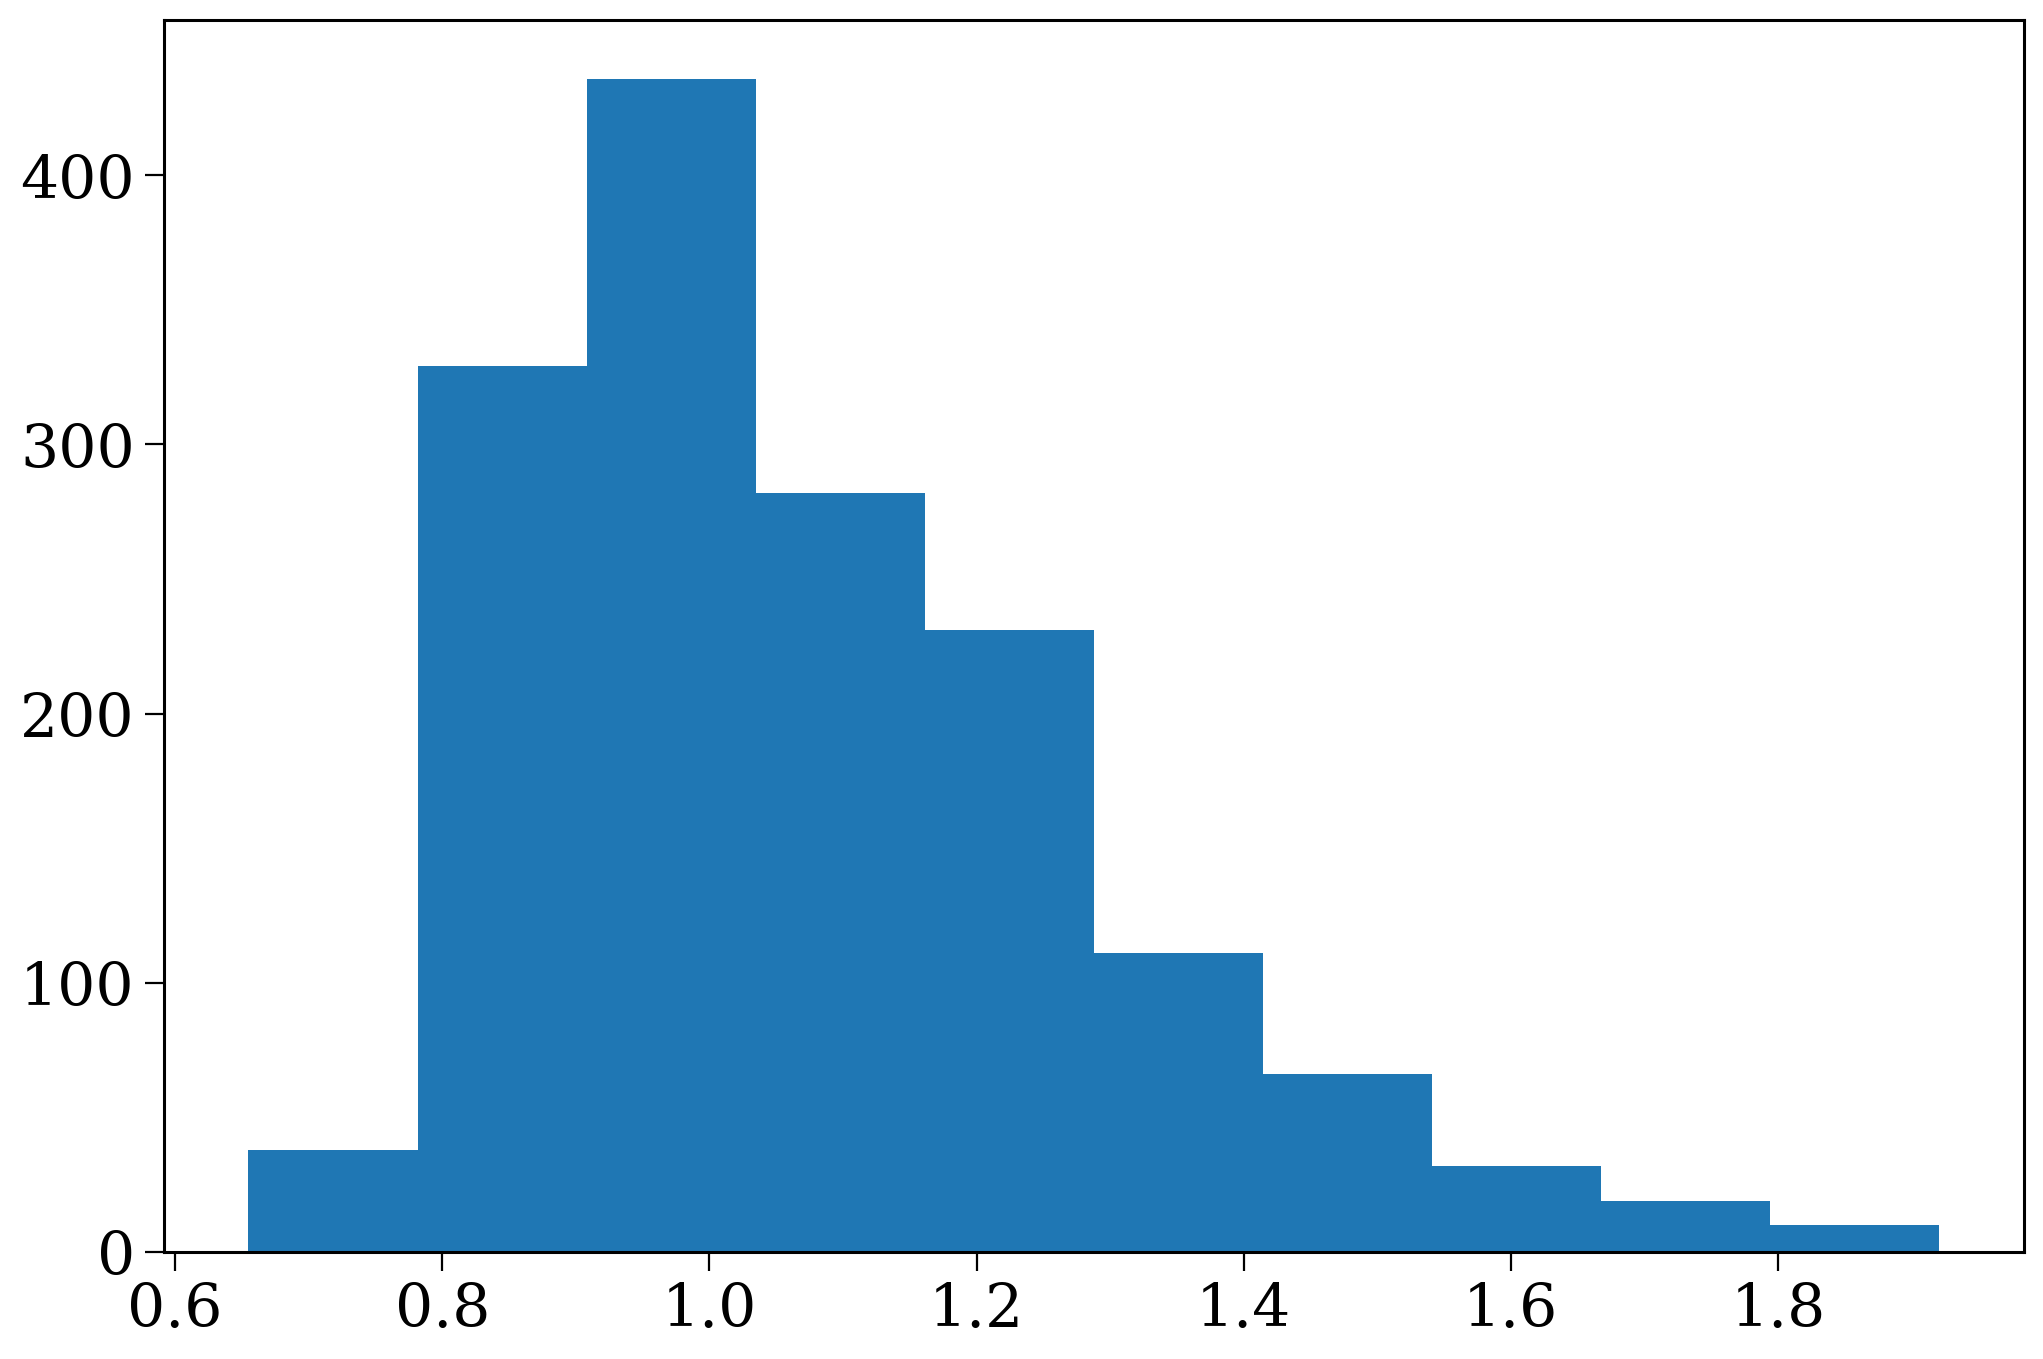

In [192]:
plt.hist(np.log10(p_runaways.initC["mass_2"]))

# Difference between theory and observation

In [48]:
sn_rows = p.bpp.loc[kicked_bin_nums][(p.bpp.loc[kicked_bin_nums]["evol_type"] == 15) | (p.bpp.loc[kicked_bin_nums]["evol_type"] == 16)]

In [61]:
p.galactic_potential.circular_velocity(p.orbits[1000].pos.xyz)

<Quantity [59.45393803, 59.64681425, 59.8444326 , 60.04656146, 60.25296578,
           60.4634064 , 60.67763939, 60.89541538, 61.11647878, 61.34056718,
           61.56741077, 61.79673187, 62.02824465, 62.26165504, 62.49666078,
           62.73295173, 62.97021033, 63.2081123 , 63.44632754, 63.68452111,
           63.92235445, 64.15948669, 64.395576  , 64.63028109, 64.8632626 ,
           65.09418467, 65.32271626, 65.54853263, 65.77131658, 65.99075962,
           66.20656312, 66.41843918, 66.62611147, 66.82931592, 67.02780118,
           67.22132904, 67.40967463, 67.59262657, 67.76998689, 67.94157094,
           68.1072071 , 68.26673649, 68.4200125 , 68.56690035, 68.70727649,
           68.84102808, 68.96805229] km / s>

In [ ]:
sn_distances = np.zeros(len(kicked_bin_nums)) * u.kpc
child_orbits = p.orbits[kicked_mask]
parent_orbits = particle_orbits[p.initC.loc[kicked_bin_nums]["particle_id"].values]
for i in range(len(kicked_bin_nums)):
    parent_orbit = parent_orbits[i]
    child_orbit = child_orbits[i]
    if isinstance(child_orbit, list):
        child_orbit = child_orbit[0]

    sn_time = sn_rows["tphys"].iloc[i]

    parent_pos = parent_orbit.pos[np.argmin(abs(parent_orbit.t - (sn_time * u.Myr + parent_orbit.t[0])))]
    child_pos = child_orbit.pos[np.argmin(abs(child_orbit.t - (sn_time * u.Myr + child_orbit.t[0])))]

    sn_distances[i] = sum((parent_pos - child_pos).xyz**2)**(0.5)

In [ ]:
sn_distances_hists = [sn_distances[(p.initC.loc[kicked_bin_nums]["mass_1"].values <= 15)], sn_distances[(p.initC.loc[kicked_bin_nums]["mass_1"].values > 15)]]

In [ ]:
star_particles.sort_values("t_form")["mass"].cumsum().values

array([1.11329004e+04, 2.08887978e+04, 2.98696038e+04, ...,
       1.01650008e+08, 1.01662791e+08, 1.01674856e+08])

16265
11154
10571
5873
4377


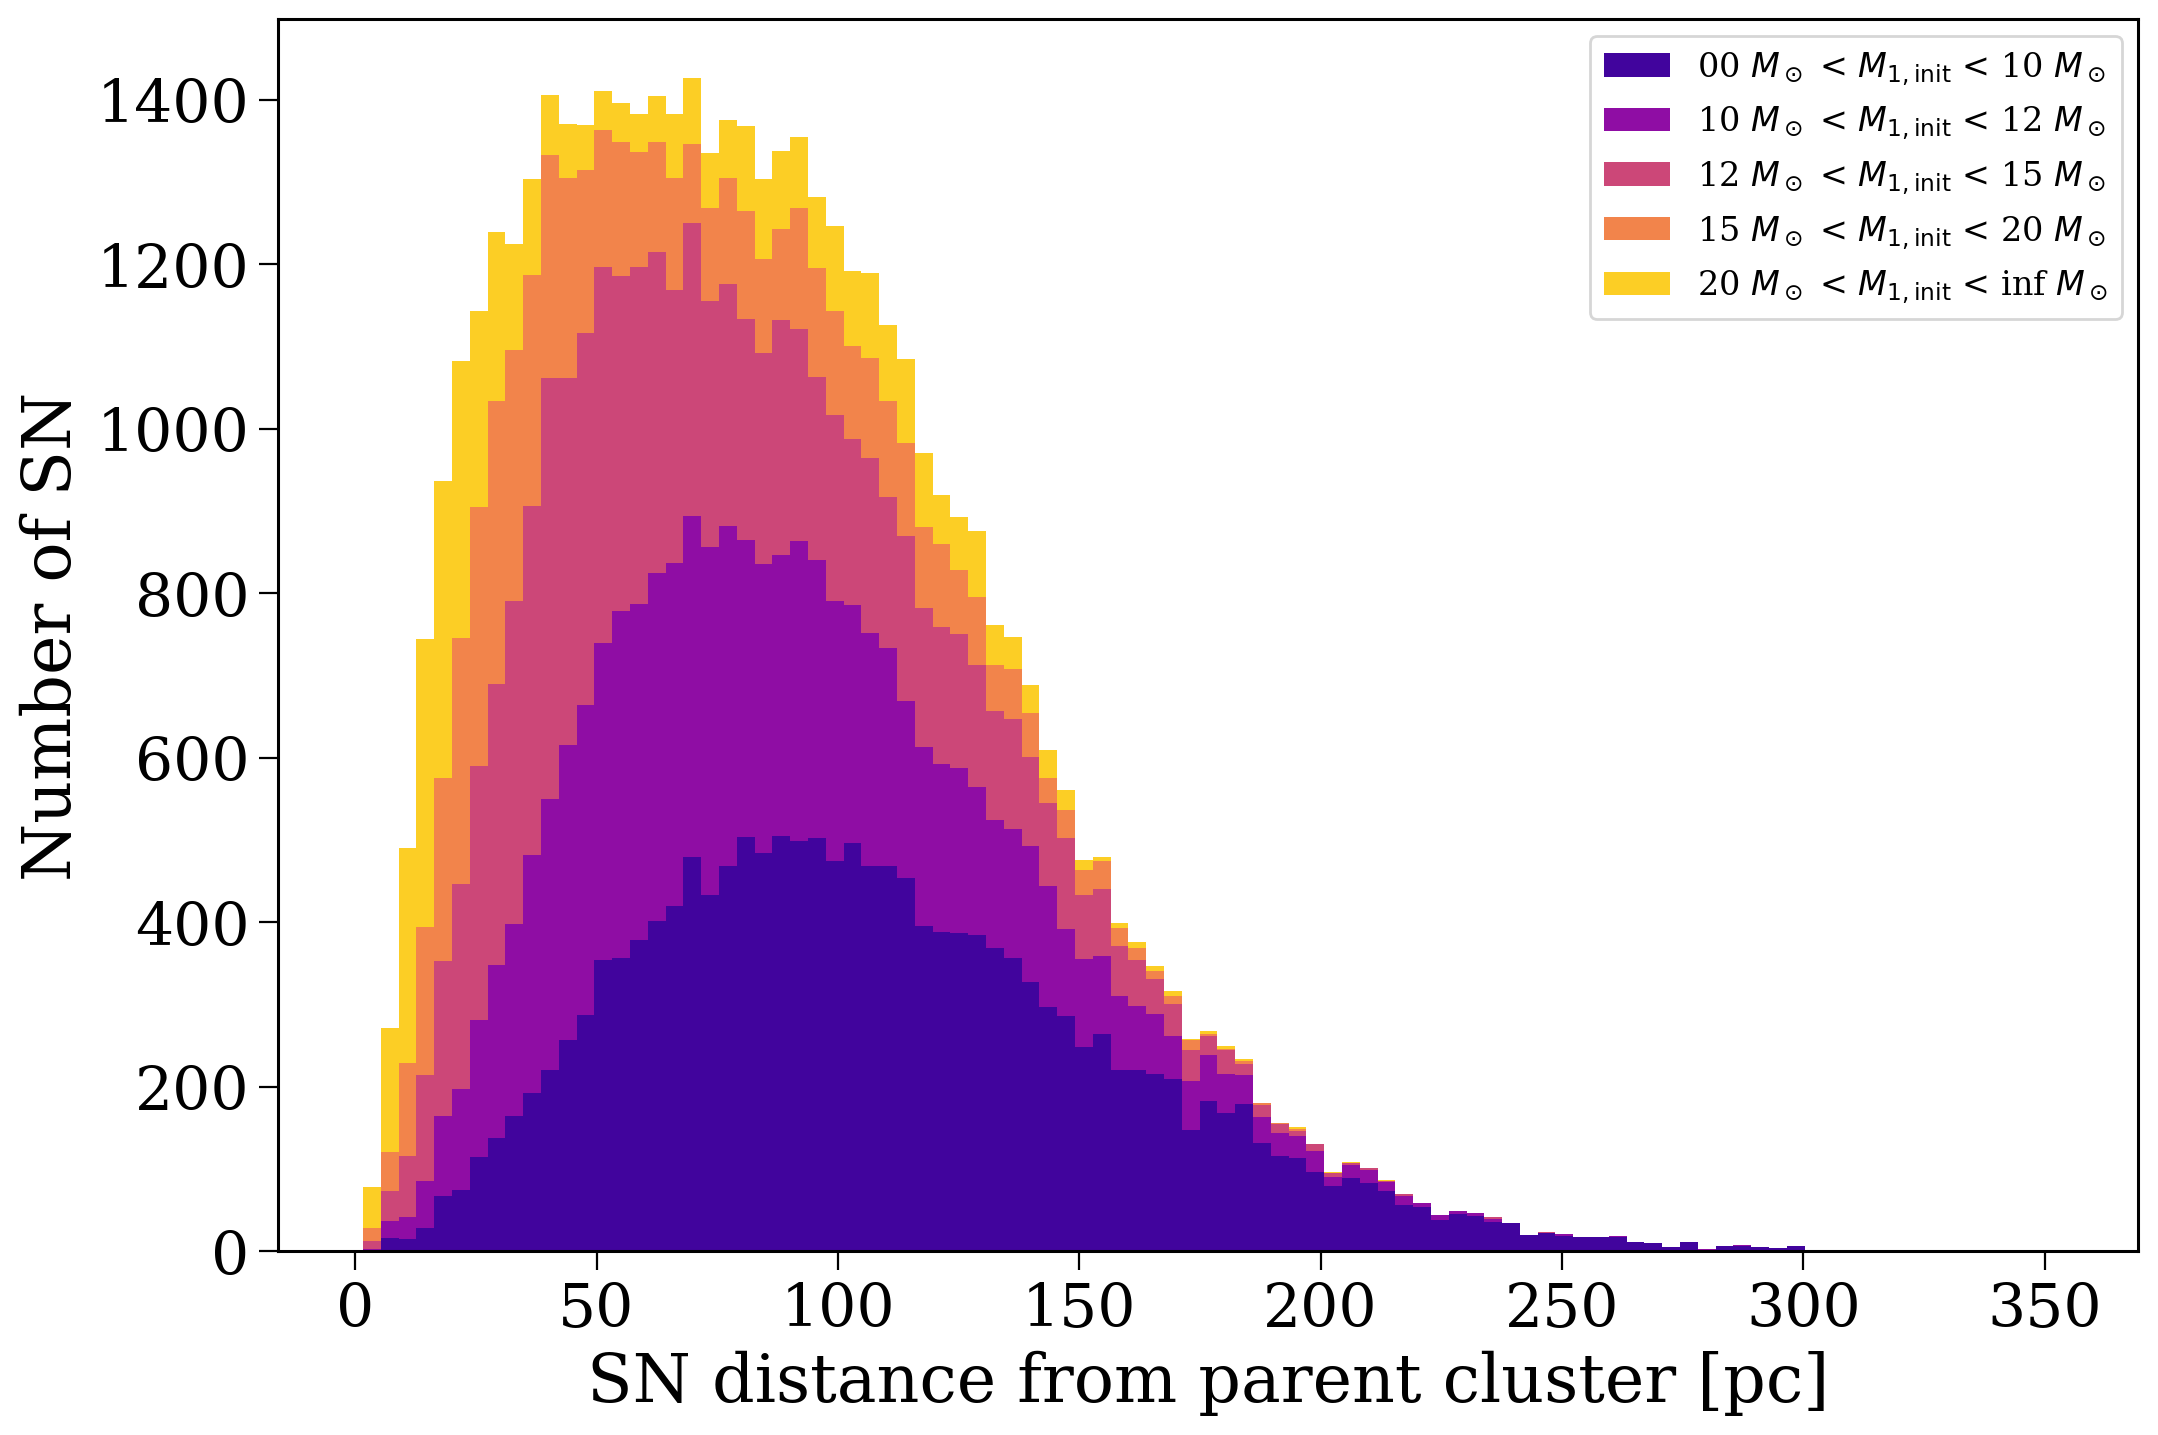

In [ ]:
mass_ranges = [(0, 10), (10, 12), (12, 15), (15, 20), (20, np.inf)]
mass_1_kicked = p.initC.loc[kicked_bin_nums]["mass_1"].values
sn_distances_hists = [sn_distances[(mass_1_kicked >= m_low) & (mass_1_kicked < m_high)].to(u.pc) for m_low, m_high in mass_ranges]

for x in sn_distances_hists:
    print(len(x))

labels = [f"{m_low:02d} $M_\odot$ < $M_{{1, \\rm init}}$ < {m_high} $M_\odot$" for m_low, m_high in mass_ranges]

plt.hist(sn_distances_hists, stacked=True, bins="fd", label=labels,
         color=plt.cm.plasma(np.linspace(0.1, 0.9, len(mass_ranges))));
plt.xlabel("SN distance from parent cluster [pc]")
plt.ylabel("Number of SN")
plt.legend(fontsize=0.5*fs)
plt.show()

Text(0, 0.5, 'Number of star particles')

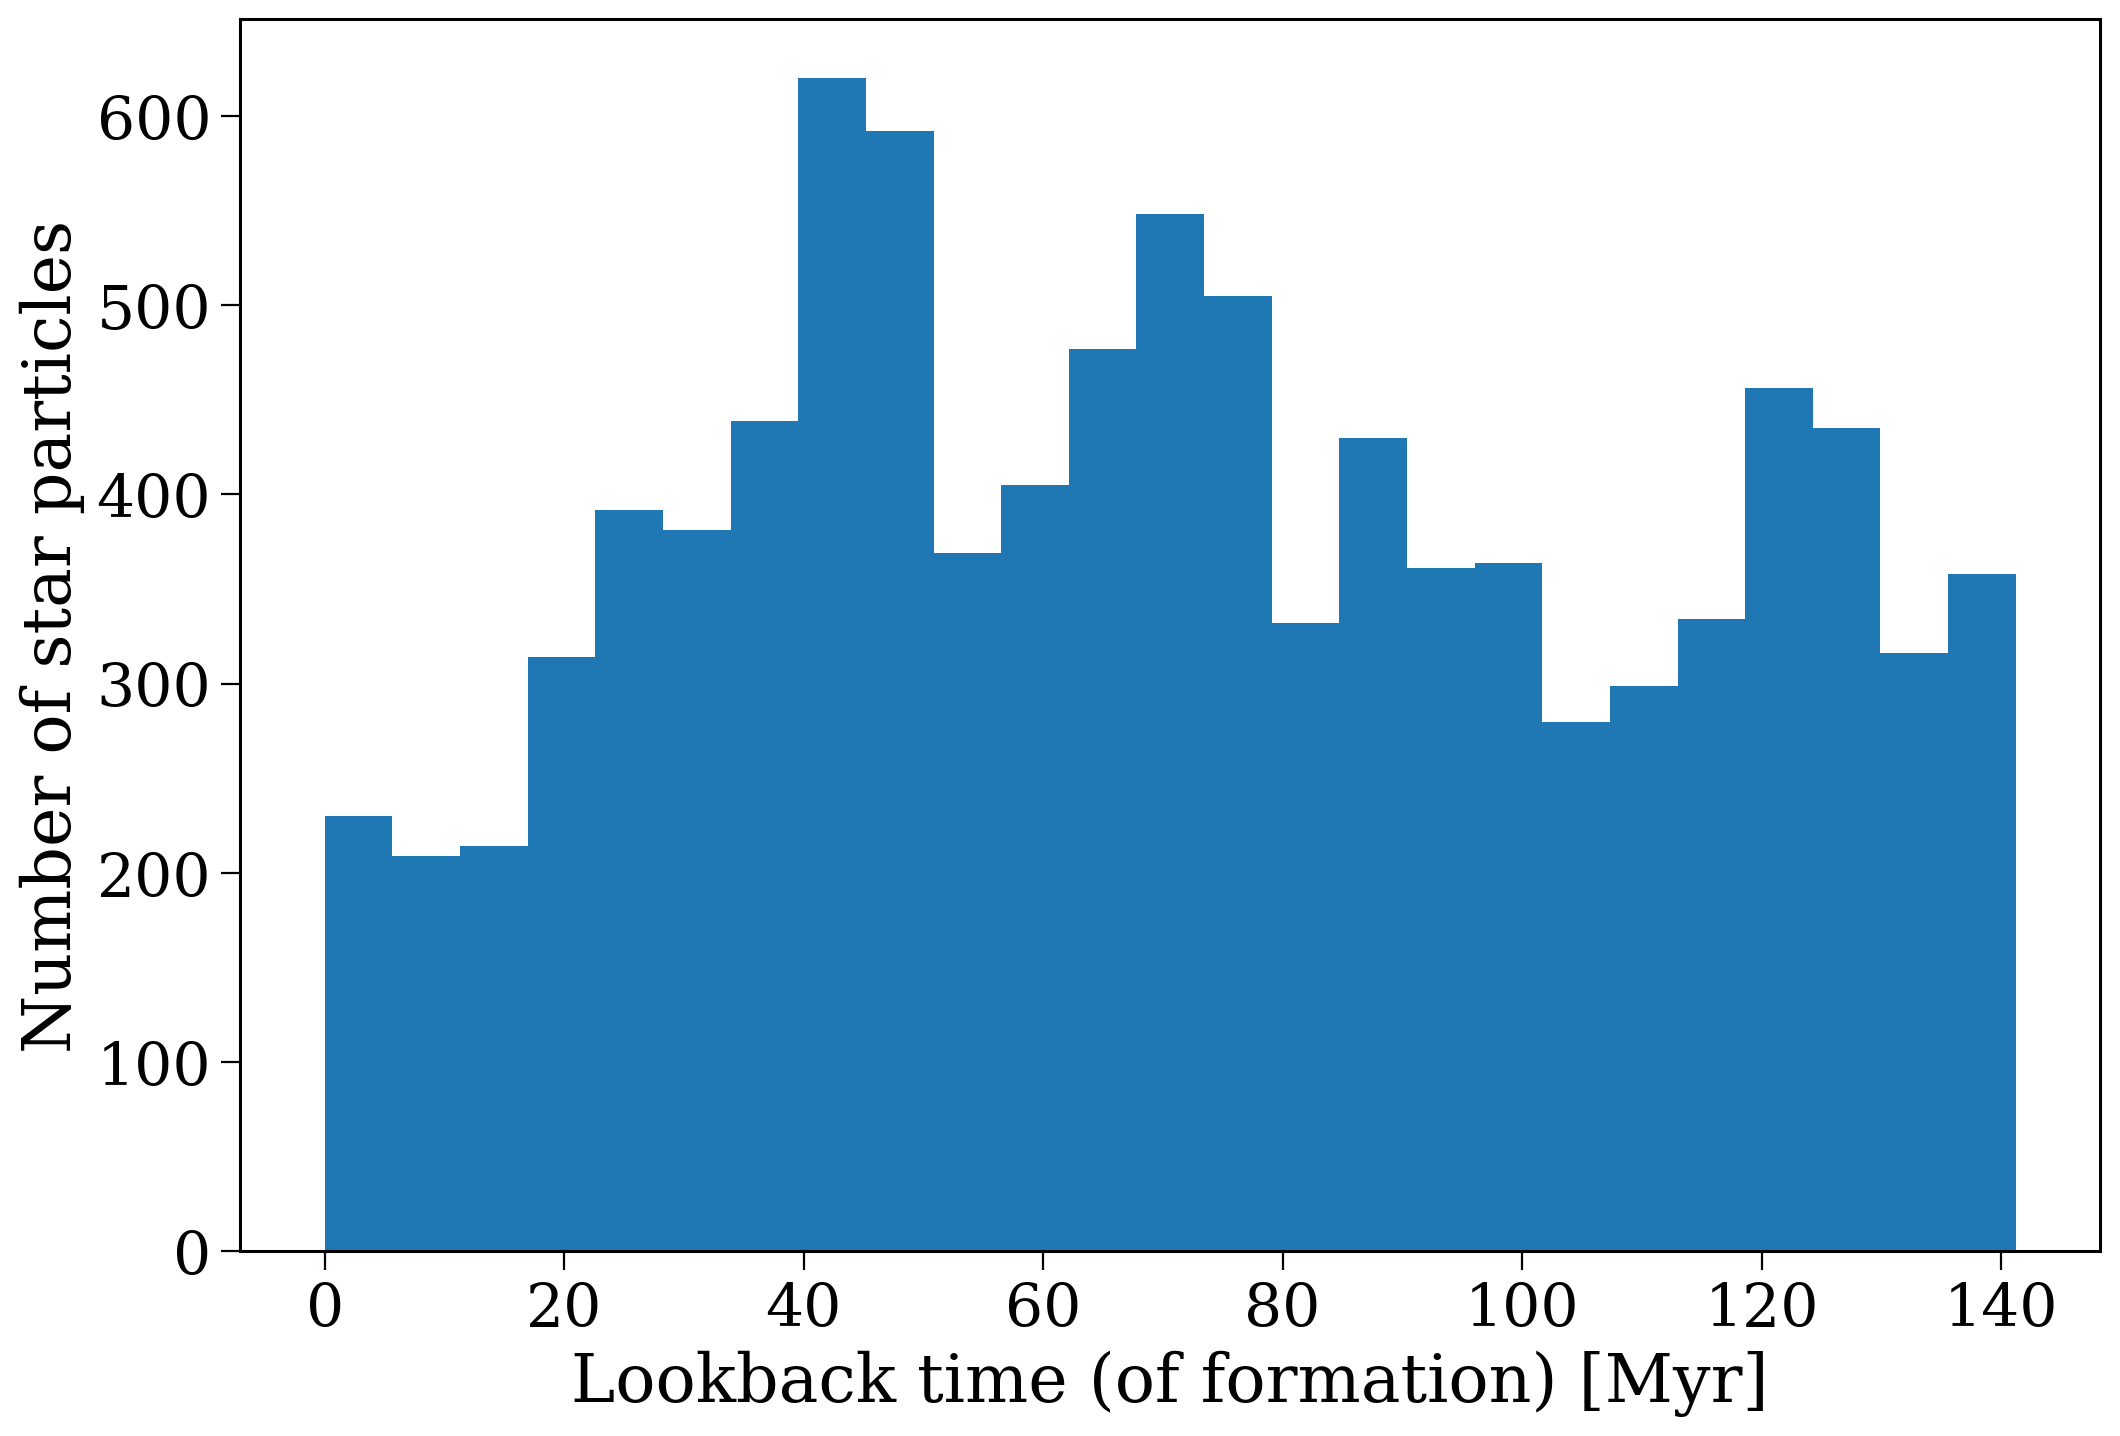

In [ ]:
plt.hist(-(star_particles["t_form"] - star_particles["t_form"].max()) * 1000, bins="fd");
plt.xlabel("Lookback time (of formation) [Myr]")
plt.ylabel("Number of star particles")

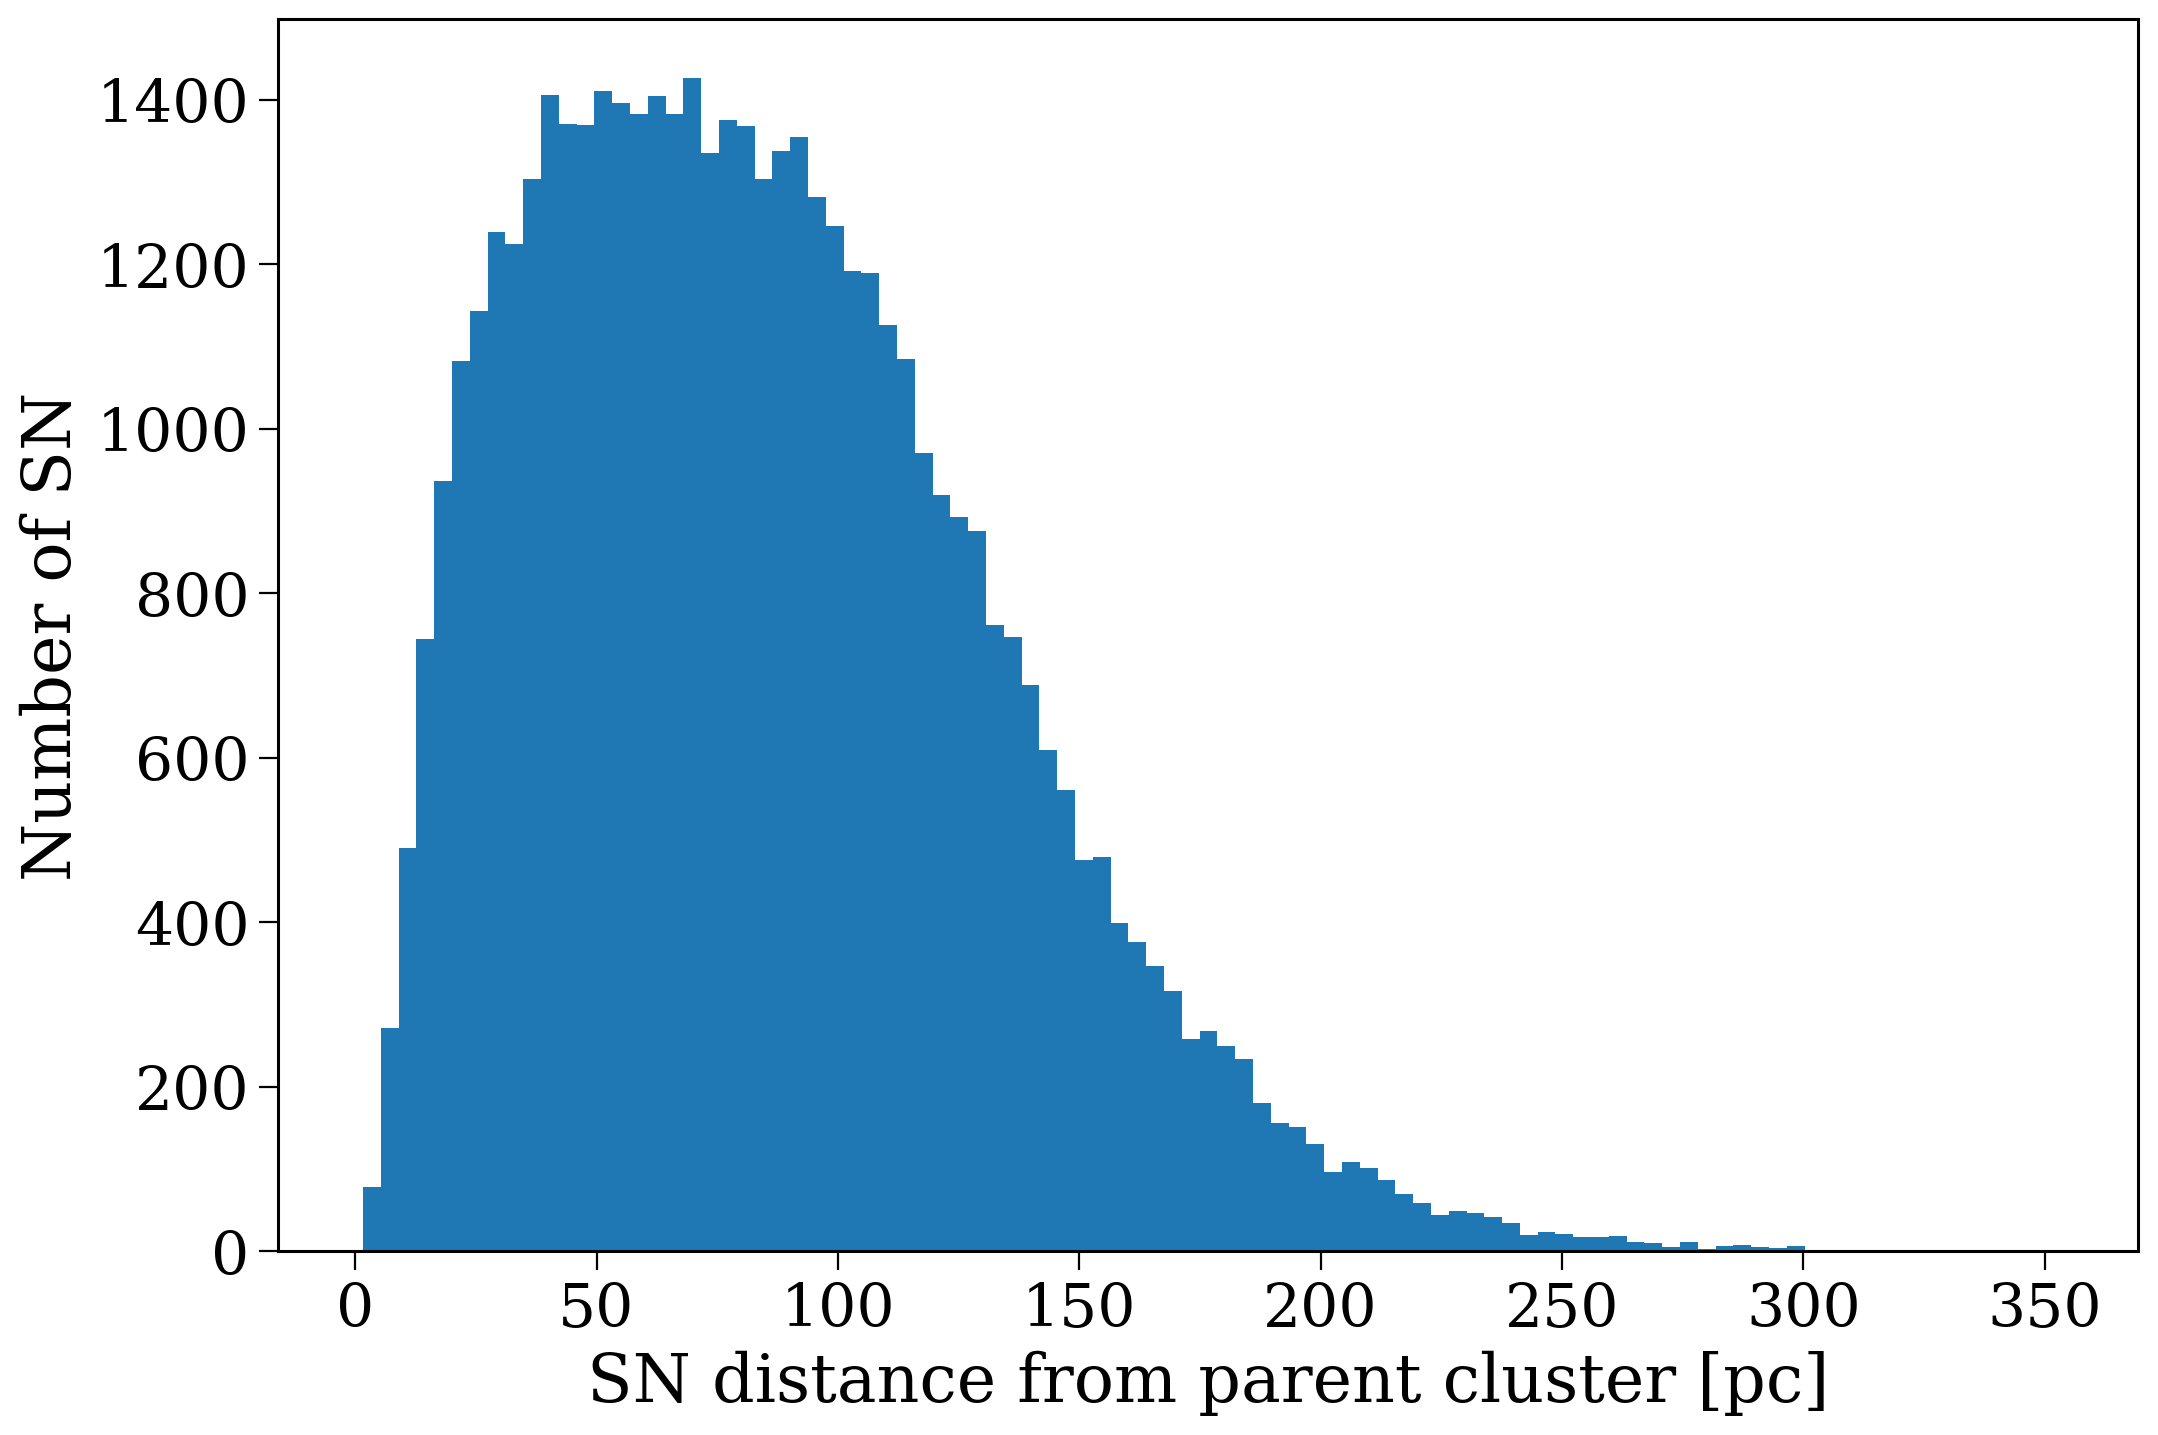

In [ ]:
plt.hist(sn_distances[sn_distances > 0 * u.kpc].to(u.pc), bins="fd");
plt.xlabel("SN distance from parent cluster [pc]")
plt.ylabel("Number of SN")
plt.show()

# COSMIC bug searching

In [128]:
hehg_at_mt_onset = p.bpp[(p.bpp["kstar_1"] == 8) & (p.bpp["evol_type"] == 3)]["bin_num"]
hehg_at_mt_end = p.bpp[(p.bpp["kstar_1"] == 8) & (p.bpp["evol_type"] == 4)]["bin_num"]
ce = p.bpp[p.bpp["evol_type"] == 7]["bin_num"]

In [146]:
started_mt_as_hehg = np.isin(p.bin_nums, hehg_at_mt_onset)
finished_mt_as_hehg = np.isin(p.bin_nums, hehg_at_mt_end)
experienced_ce = np.isin(p.bin_nums, ce)

In [147]:
started_mt_as_hehg.sum()

48760

In [151]:
(finished_mt_as_hehg & ~started_mt_as_hehg & experienced_ce).sum()

5072